# Cas Kaggle: 

## Introducció

Els telèfons intel·ligents s'han covertit en una eina necessària en el nostre dia a dia ja sigui per treballar, contactar amb els nostres éssers estimats o passar el temps mort revisant les xarxes socials. Tot i així, es requereix d'un element imprescindible que en gran part diferencia el telèfon móbil amb el que ara anomenem telèfon intel·ligent: les aplicacions. 

Actualment existeixen milions d'aplicacions diferents disponibles per a la seva descàrrega i és decisió de l'usuari escollir quina és la que s'adequa a les seves necessitats.

<img src="images/top-apps.jpg" width="40%">

El manteniment dels serveis d'aquestes aplicacions pot ser un treball costós temporal o financerament i les persones encarregades del desenvoluament de noves aplicacions han d'escollir si rebre ingressos a partir d'oferir publicitat a la seva app o oferir la seva aplicació a canvi d'un preu fixe.

És per aquesta raó que analitzarem el dataset de Kaggle [Google Play Store Apps](www.kaggle.com/datasets/lava18/google-play-store-apps), on s'emmagatzema informació sobre 10 mil de les aplicacions disponibles a la Play Store, amb l'objectiu de crear un model predictiu amb el qual obtenir si una app será de pagament o gratuïta a partir de la resta d'atributs de l'aplicació. D'aquesta forma es pot rebre una recomanació a partir de les característiques de les aplicacions ja publicades.


Per fer-ho seguirem els passos següents:

* Preparació i neteja de les dades

* Anàlisi de les dades

* Selecció del model

* Crossvalidation

* Anàlisi de resultats


## Dependencies

Importem les llibreries necessàries per l'execució del notebook:

In [379]:
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import datetime as dt
import seaborn as sns

## 1. Preparació i neteja de les dades

En aquest primer apartat analitzarem quines són les dades disponibles al dataset i les prepararem i netejarem per el seu ús en l'entrenament i testejat del model d'aprenentatge.

### 1.1. Informació de les dades

Per començar carreguem el dataset des del fitxer i mostrem algunes files.

In [380]:
# Carreguem el dataset
df = pd.read_csv('data/googleplaystore.csv', header=0, delimiter=',')
data = df.values

print("Dimensionalitat de la BBDD:", df.shape)
df.head(5)

Dimensionalitat de la BBDD: (10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Observem que el dataset compta amb un total de 13 atributs:

* **App:** Nom de l'aplicació.
* **Category:** Categoria assignada a laplicació.
* **Rating:** Punctuació mitjana dels usuaris. Valor decimal entre 0 i 5.
* **Reviews:** Nombre de ressenyes rebudes dels usuaris.
* **Size:** Tamany de l'aplicació en Bytes.
* **Installs:** Nombre aproximat d'instal·lacions.
* **Type:** Tipus indicant si l'aplicació és de pagament.
* **Price:** Preu de compra en dòlars ($).
* **Content Rating:** Indica el públic a qui va dirigida l'aplicació.
* **Genres:** Gèneres assignats a més de la categoría principal.
* **Last Updated:** Data de la darrera actualització emesa.
* **Current Ver:** Versió actual.
* **Android Ver:** Versions d'Android Compatibles.


A continuació comprovem si existeixen elements buits per cadascún dels atributs.

In [381]:
print("Nombre de valors no existents:")
print(df.isnull().sum())

Nombre de valors no existents:
App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


Observem que als atributs *Rating*, *Type*, *Content Rating*, *Current Ver* i *Android Ver* en tenen algún element inexistent. Per tant caldrà omplir aquests buits.

In [382]:
print("Tipus de dades a cada columna:")
print(df.dtypes)

Tipus de dades a cada columna:
App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


Quan l'atribut s'indica de tipus *object* ens indica que existeixen diversos tipus de dades en aquella columna. Per tant també cal netejar les dades que puguin ser de tipus diferent a l'esperat, ja que poden ser valor erronis.

### 1.2. Preprocessament de dades

Inicialment eliminem la columna de l'atribut *App*, ja que emmagatzema valors únics que no aporten informació útil al model i serveixen únicament com a identificadors.

In [383]:
#Eliminem la columna 'App'
dataset = df.drop(['App'], axis=1)
data = dataset.values

print("Columnes restants:")
print(dataset.columns.values)

Columnes restants:
['Category' 'Rating' 'Reviews' 'Size' 'Installs' 'Type' 'Price'
 'Content Rating' 'Genres' 'Last Updated' 'Current Ver' 'Android Ver']


Els atributs *Category*, *Type*, *Content Rating* i *Genres* són categórics i de tipus string. Per poder ser utilitzats pel model cal codificar-los en valors numèrics.

In [384]:
le = preprocessing.LabelEncoder()

# Codifiquem l'atribut 'Category'
dataset["Category"] = le.fit_transform(dataset["Category"])

# Codifiquem l'atribut 'Type'
dataset["Type"] = le.fit_transform(dataset["Type"])

# Codifiquem l'atribut 'Content Rating'
dataset["Content Rating"] = le.fit_transform(dataset["Content Rating"])

# Codifiquem l'atribut 'Genres'
dataset["Genres"] = le.fit_transform(dataset["Genres"])


En els atributs *Size* i *Installs* ens nombres s'emagatzemen en format en format '100k' i '10,000+' respectivament. Hem de formatejarlos a un nombre sencer. 

A més, a *Android Ver* la versió va acompanyada de '*and up*' indicant que s'accepten versions superiors. Cal deixar només el nombre de versió, el qual tranformarem en un sencer eliminant els punts que separen els números. També eliminem aquests punts a l'atribut *Current Ver* per poder passar-lo a numèric.

Tembé canviar el format a *Price*, ja que en valors diferents a 0 el format del preu és semblant a '*$0.99*' i caldrà eliminar aquest símbol '*$*' inicial.

In [385]:
#Formatejat de 'Size'. 1k --> 1000 ; 1M --> 1000000
column = dataset["Size"].replace({"k":"*1e3", "M":"*1e6"}, regex=True)
for x in range(len(column)):
    try:
        column[x] = pd.eval(column[x])
    except SyntaxError:
        pass
dataset["Size"] = column

# Formatejat de 'Installs'. 10,000 --> 10000
column = dataset["Installs"].str.replace("+", "", regex=True)
column = column.str.replace(",", "", regex=True)
dataset["Installs"] = column

#Formatejat de 'Android Ver'. 1.0.3.0 and up --> 1030
column = dataset["Android Ver"].str.replace(" and up", "", regex=True)
column = column.str.replace(".", "", regex=True)
dataset["Android Ver"] = column

#Formatejat de 'Current Ver'. 1.0.3.0 --> 1030
dataset["Current Ver"] = dataset["Current Ver"].str.replace(".", "", regex=True)

#Formatejat de 'Price'. $0.99 --> 0.99
dataset["Price"] = dataset["Price"].str.replace("$", "", regex=True)


Farem servir la funció *to_numeric()* amb l'argument *error='coerce'* per eliminar valors erronis als atributs numèrics i substituir-los per NaN. Els nostres atributs numèrics són *Rating*, *Reviews*, *Size*, *Installs*, *Price*, *Current Ver* i *Android Ver*.

In [386]:
# Passar a valors numérics i eliminar valors erronis (omplir amb NaN).
cols = ["Rating", "Reviews", "Size", "Installs", "Price", "Current Ver", "Android Ver"]
for x in cols:
    dataset[x] = pd.to_numeric(dataset[x], errors='coerce')

A l'atribut *Last Updated* s'emmagatzemen dates en format '*Month DD, YYYY*'. Per poder processar-les les transformarem a temps Unix, és a dir, nombre de segons des de l'1 de gener de 1970.

In [387]:
#Pas de dates a temps Unix
dataset["Last Updated"] = pd.to_datetime(dataset["Last Updated"], format='%B %d, %Y', errors='coerce')
dataset["Last Updated"] = (dataset["Last Updated"] - dt.datetime(1970,1,1)).dt.total_seconds()


Per acabar omplirem els valors buits presents al dataset per la mitjana dels valors de cada columna utilitzant *SimpleImputer* de la llibreria *sklearn*.

In [388]:
print("Nombre de valors no existents:")
print(dataset.isnull().sum())

Nombre de valors no existents:
Category             0
Rating            1474
Reviews              1
Size              1696
Installs             1
Type                 0
Price                1
Content Rating       0
Genres               0
Last Updated         1
Current Ver       1872
Android Ver       1386
dtype: int64


In [389]:
#Omplim valors buits
data = dataset.values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imp_mean.fit_transform(data)

#Actualitzem dataset
dataset = pd.DataFrame(data=data, columns=list(dataset.columns))
data = dataset.values

Amb aixó les dades ja es troben preparades per ser treballades pel model. A continuació comprovem que després del preprocessament de les dades ja que no existeixen dades buides i mostrem algunes files del dataset per veure que es troben en format correcte.

In [390]:
print("Nombre de valors no existents:")
print(dataset.isnull().sum())

print("Estat del dataset:")
dataset.head(5)

Nombre de valors no existents:
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64
Estat del dataset:


,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,1.0,4.1,159.0,19000000.0,10000.0,1.0,0.0,1.0,9.0,1.515283e+09,1.000000e+02,403.0
1,1.0,3.9,967.0,14000000.0,500000.0,1.0,0.0,1.0,12.0,1.515974e+09,2.000000e+02,403.0
2,1.0,4.7,87510.0,8700000.0,5000000.0,1.0,0.0,1.0,9.0,1.533082e+09,1.240000e+02,403.0
3,1.0,4.5,215644.0,25000000.0,50000000.0,1.0,0.0,4.0,9.0,1.528416e+09,7.993792e+10,42.0
4,1.0,4.3,967.0,2800000.0,100000.0,1.0,0.0,1.0,11.0,1.529453e+09,1.100000e+01,44.0


### 1.3. EDA (exploratory data analysis)

Ara que ja tenim les dades netejades podem veure quines són les correlacions existents entre els atributs del dataset.

Per començar mostrem algunes dades estadístiques del dataset per veure l'estat d'aquest més a fons.

In [391]:
print("Per veure estadístiques dels atributs numèrics de la BBDD:")
dataset.describe()

Per veure estadístiques dels atributs numèrics de la BBDD:


,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,10841.000000,10841.000000,1.084100e+04,1.084100e+04,1.084100e+04,10841.000000,10841.000000,10841.000000,10841.000000,1.084100e+04,1.084100e+04,10841.000000
mean,17.723734,4.193338,4.441529e+05,2.151653e+07,1.546434e+07,1.073886,1.027368,1.465455,64.875842,1.511247e+09,7.993792e+10,102.652988
std,8.354659,0.499557,2.927626e+06,2.074654e+07,8.502544e+07,0.262302,15.948968,1.007047,33.059316,3.409282e+07,2.387294e+12,125.933865
min,0.000000,1.000000,0.000000e+00,8.500000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.274400e+09,1.000000e+00,10.000000
25%,12.000000,4.100000,3.800000e+01,5.900000e+06,1.000000e+03,1.000000,0.000000,1.000000,38.000000,1.505866e+09,5.200000e+01,40.000000
50%,15.000000,4.200000,2.094000e+03,1.800000e+07,1.000000e+05,1.000000,0.000000,1.000000,68.000000,1.527120e+09,2.510000e+02,42.000000
75%,26.000000,4.500000,5.479800e+04,2.600000e+07,5.000000e+06,1.000000,0.000000,1.000000,97.000000,1.532045e+09,1.113900e+04,102.652988
max,33.000000,19.000000,7.815831e+07,1.000000e+08,1.000000e+09,3.000000,400.000000,6.000000,119.000000,1.533686e+09,9.800000e+13,403.000000


A continuació veurem la matriu de correlacions a la qual es relacionen tots els atributs del dataset.

<IPython.core.display.Javascript object>


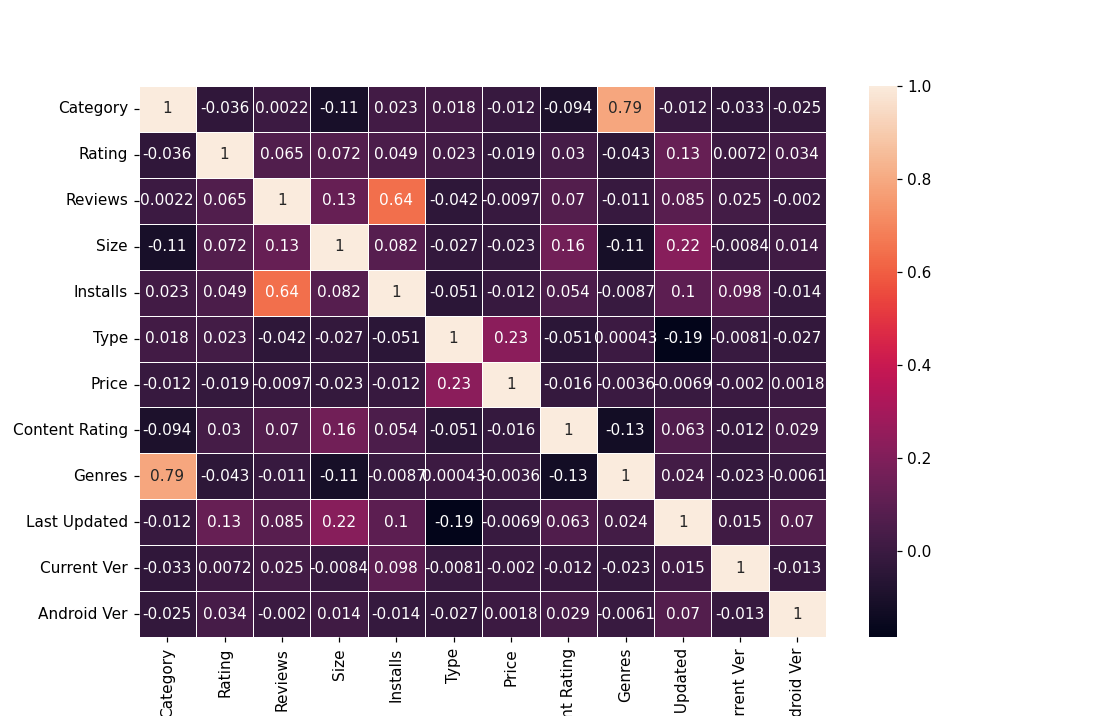

In [392]:
# Mirem la correlació entre els atributs del dataset
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Observem que en aquest dataset les correlacions per lo general són bastant baixes. La correlació entre els atributs *Category* i *Genres* no ens indica gran cosa, ja que és a raó de que *Genres* té el contingut de *Category* sumat a  altres categories assignades a aquella aplicació.